**Olympics_study**



This project merely started with my excitement to watch every competition at Olympics and the love to play with data. Like many of us, knowing the process behind all the hardship of athletes made me curious to know how much past data is useful for future planning and analysis. I decided to do some number crunching on 124 years of Olympics to see which are the best performing countries at the Olympics and what makes them great!
I have gathered data of Olympics performances from year 1900 to 2020 and in their relation to the country’s GDP, population, infra-structure, economics.

I use the [olympics dataset](https://www.kaggle.com/heesoo37/120-years-of-olympic-history-athletes-and-results),[2021 olympics report](https://www.kaggle.com/berkayalan/2021-olympics-medals-in-tokyo) from kaggle, and merged it with the country wise [gdp](https://www.kaggle.com/resulcaliskan/countries-gdps) and [population data](https://www.kaggle.com/centurion1986/countries-population).



In [231]:
import os
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


The first five rows of the olympics data are shown below. We have 271,116 rows and 15 columns. Variables include Name, Sex, Age, Height, Weight of the athlete,their team name, sport, event and the year, season, city of the olympics he/she took part in. In addition, the data captures the medal won (if any) by the athlete.

In [232]:
# Read in the data set
olympics = pd.read_csv('../input/120-years-of-olympic-history-athletes-and-results/athlete_events.csv')
olympics.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


**Data Cleaning and Exploration**

# 1) Missing Values
Finding and printing column wise missing values we have in the dataset 'Olympics'

In [233]:
print(olympics.isnull().sum())

ID             0
Name           0
Sex            0
Age         9474
Height     60171
Weight     62875
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal     231333
dtype: int64


We can see Height,Weight and Age have a lot of missing values. Medals have a NaN in about 2,31,333 rows. This can be explained since not all participating athletes have won medals. Let's replace these missing values by 'Did not win' or 'DNW'.

In [234]:
olympics['Medal'].fillna('DNW', inplace = True)

In [235]:
# As expected the NaNs in the 'Medal' column disappear!
print(olympics.isnull().sum())

ID            0
Name          0
Sex           0
Age        9474
Height    60171
Weight    62875
Team          0
NOC           0
Games         0
Year          0
Season        0
City          0
Sport         0
Event         0
Medal         0
dtype: int64


# 2) NOC - National Olympic Committee
The organizations which send their sport persons to participate in the Olympics.
Are all NOCs linked to a unique team? We can find this out by taking a unique subset 
of just the NOC and team columns and taking a value count.

In [236]:
print(olympics.loc[:, ['NOC', 'Team']].drop_duplicates()['NOC'].value_counts().head())

FRA    160
USA     97
GBR     96
SWE     52
NOR     46
Name: NOC, dtype: int64


So NOC code 'FRA' is associated with 160 teams? That sounds prepostorous! Let's use a master of NOC to country mapping to correct this.

The NOC dataset has the NOC code and the corresponding Country Name. The first five rows of the data are shown below -

In [237]:
# Lets read in the noc_country mapping first
noc_country = pd.read_csv('../input/120-years-of-olympic-history-athletes-and-results/noc_regions.csv')
noc_country.drop('notes', axis = 1 , inplace = True)
noc_country.rename(columns = {'region':'Country'}, inplace = True)

noc_country.head()

,NOC,Country
0,AFG,Afghanistan
1,AHO,Curacao
2,ALB,Albania
3,ALG,Algeria
4,AND,Andorra


We will merge the original dataset with the NOC master using the **NOC code as the primary key**. This has to be a left join since we want all participating countries to remain in the data even if their NOC-Country is not found in the master. We can easily correct those manually.

In [238]:
# merging
olympics_merge = olympics.merge(noc_country,
                                left_on = 'NOC',
                                right_on = 'NOC',
                                how = 'left')

Even after merging, we can see that the below NOC codes in the Olympics data had no counterpart in the NOC master data.

In [239]:
# Do we have NOCs that didnt have a matching country in the master?
olympics_merge.loc[olympics_merge['Country'].isnull(),['NOC', 'Team']].drop_duplicates()

,NOC,Team
578,SGP,Singapore
6267,ROT,Refugee Olympic Athletes
44376,SGP,June Climene
61080,UNK,Unknown
64674,TUV,Tuvalu
80986,SGP,Rika II
108582,SGP,Singapore-2
235895,SGP,Singapore-1


Looking at their 'Team' names we can manually insert the correct values into the olympics data.

Let's put these values in Country, which we can confirm from noc_country - <br>
    1. SGP - Singapore
    2. ROT - Refugee Olympic Athletes
    3. UNK - Unknown
    4. TUV - Tuvalu 

In [240]:
# Replace missing Teams by the values above.

olympics_merge['Country'] = np.where(olympics_merge['NOC']=='SGP', 'Singapore', olympics_merge['Country'])
olympics_merge['Country'] = np.where(olympics_merge['NOC']=='ROT', 'Refugee Olympic Athletes', olympics_merge['Country'])
olympics_merge['Country'] = np.where(olympics_merge['NOC']=='UNK', 'Unknown', olympics_merge['Country'])
olympics_merge['Country'] = np.where(olympics_merge['NOC']=='TUV', 'Tuvalu', olympics_merge['Country'])


# Put these values from Country into Team
olympics_merge.drop('Team', axis = 1, inplace = True)
olympics_merge.rename(columns = {'Country': 'Team'}, inplace = True)

Checking again for mapping of NOC to team we find that each is mapped to a single value! 

# Merge GDP data
To effectively study factors that affect the medal tally of a country, we need to import the Country-Year wise GDP data. THe GDP data has Country name, code, year and the GDP value. We will remove some unnecessary columns [Indicator Name and Indicator Code].With the changes the GDP data is shown below-

In [241]:
w_gdp = pd.read_csv('../input/country-wise-gdp-data/world_gdp.csv', skiprows = 3)

# Remove unnecessary columns
w_gdp.drop(['Indicator Name', 'Indicator Code'], axis = 1, inplace = True)

# The columns are the years for which the GDP has been recorded. This needs to brought into a single column for efficient
# merging.
w_gdp = pd.melt(w_gdp, id_vars = ['Country Name', 'Country Code'], var_name = 'Year', value_name = 'GDP')

# convert the year column to numeric
w_gdp['Year'] = pd.to_numeric(w_gdp['Year'])

w_gdp.head()

,Country Name,Country Code,Year,GDP
0,Afghanistan,AFG,1960,5.377778e+08
1,Albania,ALB,1960,NaN
2,Algeria,DZA,1960,2.723649e+09
3,American Samoa,ASM,1960,NaN
4,Andorra,AND,1960,NaN


Before we actually merge, lets check if NOCs in the olympics data match with those in the Country Code.

In [242]:
len(list(set(olympics_merge['NOC'].unique()) - set(w_gdp['Country Code'].unique())))

108

So, 108 NOCs in the olympics dataset dont have representation in the gdp data country codes. Is the name of the country a better way to merge?

In [243]:
len(list(set(olympics_merge['Team'].unique()) - set(w_gdp['Country Name'].unique())))

6

So this looks promising! Only 6! Let's do what we can easily achieve, add a country code for each Team in the olympics dataset first and then merge using the Country Code. The data now has GDP data attached!

In [244]:
# Merge to get country code
olympics_merge_ccode = olympics_merge.merge(w_gdp[['Country Name', 'Country Code']].drop_duplicates(),
                                            left_on = 'Team',
                                            right_on = 'Country Name',
                                            how = 'left')

olympics_merge_ccode.drop('Country Name', axis = 1, inplace = True)

# Merge to get gdp too
olympics_merge_gdp = olympics_merge_ccode.merge(w_gdp,
                                                left_on = ['Country Code', 'Year'],
                                                right_on = ['Country Code', 'Year'],
                                                how = 'left')

olympics_merge_gdp.drop('Country Name', axis = 1, inplace = True)

# Merge Population Data
Apart from GDP, population is also of import when looking at a countries performance. There are two trains of thought for this - <br>
1. Higher populations mean a bigger talent pool to choose from,
2. Its not GDP alone but GDP per capita that decides how much resources a country has.

In [245]:
# Read in the population data
w_pop = pd.read_csv('../input/country-wise-population-data/world_pop.csv')

w_pop.drop(['Indicator Name', 'Indicator Code'], axis = 1, inplace = True)

w_pop = pd.melt(w_pop, id_vars = ['Country', 'Country Code'], var_name = 'Year', value_name = 'Population')

# Change the Year to integer type
w_pop['Year'] = pd.to_numeric(w_pop['Year'])

w_pop.head()

,Country,Country Code,Year,Population
0,Aruba,ABW,1960,54211.0
1,Afghanistan,AFG,1960,8996351.0
2,Angola,AGO,1960,5643182.0
3,Albania,ALB,1960,1608800.0
4,Andorra,AND,1960,13411.0


In [246]:

olympics_complete = olympics_merge_gdp.merge(w_pop,
                                            left_on = ['Country Code', 'Year'],
                                            right_on= ['Country Code', 'Year'],
                                            how = 'left')

olympics_complete.drop('Country', axis = 1, inplace = True)

olympics_complete.head()

,ID,Name,Sex,Age,Height,Weight,NOC,Games,Year,Season,City,Sport,Event,Medal,Team,Country Code,GDP,Population
0,1,A Dijiang,M,24.0,180.0,80.0,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,DNW,China,CHN,4.269160e+11,1.164970e+09
1,2,A Lamusi,M,23.0,170.0,60.0,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,DNW,China,CHN,8.560550e+12,1.350695e+09
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,DNW,Denmark,DNK,NaN,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark,DNK,NaN,NaN
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,DNW,Netherlands,NLD,2.585680e+11,1.476009e+07



There are a lot of missing values in the result data - the main reasons are the attributes of the countries not found in the GDP and population masters and also the fact that Population and GDP are only for 1961 onwards while Olympics data is from 1896. Therefore, let's consider only data from 1961 onwards.

In [247]:
olympics_complete.isnull().sum()

ID                  0
Name                0
Sex                 0
Age              9474
Height          60171
Weight          62875
NOC                 0
Games               0
Year                0
Season              0
City                0
Sport               0
Event               0
Medal               0
Team                0
Country Code     1397
GDP             86925
Population      65120
dtype: int64

In [248]:
# Lets take data from 1961 onwards only and for summer olympics only
olympics_complete_subset = olympics_complete.loc[(olympics_complete['Year'] > 1960) & (olympics_complete['Season'] == "Summer"), :]

# Reset row indices
olympics_complete_subset = olympics_complete_subset.reset_index()
olympics_complete_subset.head()

,index,ID,Name,Sex,Age,Height,Weight,NOC,Games,Year,Season,City,Sport,Event,Medal,Team,Country Code,GDP,Population
0,0,1,A Dijiang,M,24.0,180.0,80.0,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,DNW,China,CHN,4.269160e+11,1.164970e+09
1,1,2,A Lamusi,M,23.0,170.0,60.0,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,DNW,China,CHN,8.560550e+12,1.350695e+09
2,31,12,Jyri Tapani Aalto,M,31.0,172.0,70.0,FIN,2000 Summer,2000,Summer,Sydney,Badminton,Badminton Men's Singles,DNW,Finland,FIN,1.255400e+11,5.176209e+06
3,32,13,Minna Maarit Aalto,F,30.0,159.0,55.5,FIN,1996 Summer,1996,Summer,Atlanta,Sailing,Sailing Women's Windsurfer,DNW,Finland,FIN,1.320990e+11,5.124573e+06
4,33,13,Minna Maarit Aalto,F,34.0,159.0,55.5,FIN,2000 Summer,2000,Summer,Sydney,Sailing,Sailing Women's Windsurfer,DNW,Finland,FIN,1.255400e+11,5.176209e+06


### Exploratory Data Analysis

### Who has the most medals across all editions of the olympics?
Medal tally is the sum of all medals won.
Let's create a column that captures whether or not a medal was won! It would be 1 if Medal column says Gold, Silver or Bronze and 0 otherwise.

In [249]:
olympics_complete_subset['Medal_Won'] = np.where(olympics_complete_subset.loc[:,'Medal'] == 'DNW', 0, 1)

Before we find out the best olympics nations, we need to realise that each row of the data actually represents whether or not an athlete won a medal or not. This means that for team events, just a sum of the 'Medal_Won' column would give us an incorrect picture of the medal tally. 

We need to correct for this. First, lets analyse which events are team events. So, what events are team events?
#### If a team wins more than one gold medal for an event in an edition of the olympics, then that event is a team event.

In [250]:
# Check whether number of medals won in a year for an event by a team exceeds 1. This indicates a team event.
identify_team_events = pd.pivot_table(olympics_complete_subset,
                                      index = ['Team', 'Year', 'Event'],
                                      columns = 'Medal',
                                      values = 'Medal_Won',
                                      aggfunc = 'sum',
                                     fill_value = 0).drop('DNW', axis = 1).reset_index()

identify_team_events = identify_team_events.loc[identify_team_events['Gold'] > 1, :]

team_sports = identify_team_events['Event'].unique()

The list below gives names of each event where in a single edition multiple golds were given. Although these are recognised as team events, they are not actually team events. Some examples include - <br>
    1. Gymnastics Women's Balance Beam
    2. Gymnastics Men's Horizontal Bar
    3. Swimming Women's 100 metres Freestyle
    4. Swimming Men's 50 metres Freestyle

Upon analysis, I found that these are actually single events but because two athletes had the same score/time, both were awarded the gold medal. We need to remove these events from the list of team sports

In [251]:
remove_sports = ["Gymnastics Women's Balance Beam", "Gymnastics Men's Horizontal Bar", 
                 "Swimming Women's 100 metres Freestyle", "Swimming Men's 50 metres Freestyle"]

team_sports = list(set(team_sports) - set(remove_sports))

The next thing we need to do is add a column in the dataset that correctly identifies whether the event in the given record is a team event or a single event. We then use this column to correctly calculate the medal tally for each country.

In [252]:
# if an event name matches with one in team sports, then it is a team event. Others are singles events.
team_event_mask = olympics_complete_subset['Event'].map(lambda x: x in team_sports)
single_event_mask = [not i for i in team_event_mask]

# rows where medal_won is 1
medal_mask = olympics_complete_subset['Medal_Won'] == 1

# Put 1 under team event if medal is won and event in team event list
olympics_complete_subset['Team_Event'] = np.where(team_event_mask & medal_mask, 1, 0)

# Put 1 under singles event if medal is won and event not in team event list
olympics_complete_subset['Single_Event'] = np.where(single_event_mask & medal_mask, 1, 0)

# Add an identifier for team/single event
olympics_complete_subset['Event_Category'] = olympics_complete_subset['Single_Event'] + \
olympics_complete_subset['Team_Event']

Now, its time to calculate medal tally agnostic of the team size - one gold means one gold for an event. To do this we divide the number of medals by the count of winning team members. How do we get the team members? Sum of event_category column should do that for us!

In [253]:
medal_tally_agnostic = olympics_complete_subset.\
groupby(['Year', 'Team', 'Event', 'Medal'])[['Medal_Won', 'Event_Category']].\
agg('sum').reset_index()

medal_tally_agnostic['Medal_Won_Corrected'] = medal_tally_agnostic['Medal_Won']/medal_tally_agnostic['Event_Category']
medal_tally_agnostic.head()

,Year,Team,Event,Medal,Medal_Won,Event_Category,Medal_Won_Corrected
0,1964,Afghanistan,"Wrestling Men's Bantamweight, Freestyle",DNW,0,0,NaN
1,1964,Afghanistan,"Wrestling Men's Bantamweight, Greco-Roman",DNW,0,0,NaN
2,1964,Afghanistan,"Wrestling Men's Featherweight, Freestyle",DNW,0,0,NaN
3,1964,Afghanistan,"Wrestling Men's Featherweight, Greco-Roman",DNW,0,0,NaN
4,1964,Afghanistan,"Wrestling Men's Flyweight, Freestyle",DNW,0,0,NaN


In [254]:

#olympics_complete_set = olympics_complete_subset.merge(medals_21[['Country', 'Total', 'Year']].drop_duplicates(),
                                            #left_on = ['Team', 'Year'],
                                            #right_on= ['Country', 'Year'],
                                            #how = 'left')
# Put these values from Country into Team
#olympics_complete_set.drop('Country', axis = 1, inplace = True)
#olympics_complete_set.rename(columns = {'Country': 'Team'}, inplace = True)
#display(olympics_complete_set)


In [255]:
# Medal Tally.
medal_tally = medal_tally_agnostic.groupby(['Year','Team'])['Medal_Won_Corrected'].agg('sum').reset_index()

medal_tally_pivot = pd.pivot_table(medal_tally,
                     index = 'Team',
                     columns = 'Year',
                     values = 'Medal_Won_Corrected',
                     aggfunc = 'sum',
                     margins = True).sort_values('All', ascending = False)[1:5]

# print total medals won in the given period
medal_tally_pivot.loc[:,'All']

Team
USA        1387.0
Russia     1298.0
Germany    1042.0
China       545.0
Name: All, dtype: float64

Now with out study we can conclude saying the top 4 countries are 
**USA, Russia, Germany and China** <br>
They are the best countries of all time when it comes to medal tallies from 1964 to 2016. Now lets compare them with the latest data we have of **Tokyo Olympics 2020(2021)**
What do the yearwise medal tallies vs 2021 medals look like?


In [256]:
#Read in the Tokyo Medals 2021 dataset
medals_21 = pd.read_csv('../input/2021-olympics-medals-in-tokyo/Tokyo Medals 2021.csv')

medals_21.drop(['Rank By Total'], axis = 1, inplace = True)
medals_21["Country"].replace({"United States of America": "USA", "People's Republic of China": "China"}, inplace=True)
medals21= medals_21.rename(columns={"Gold Medal": "Gold", "Silver Medal": "Silver", "Bronze Medal": "Bronze"})
medals21.head()

,Country,Gold,Silver,Bronze,Total
0,USA,39,41,33,113
1,China,38,32,18,88
2,Japan,27,14,17,58
3,Great Britain,22,21,22,65
4,ROC,20,28,23,71


Text(0.5, 1.0, 'Olympic Performance Comparison')

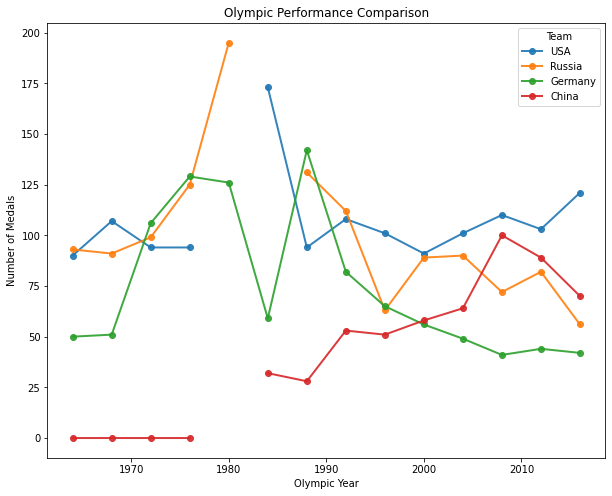

In [257]:
# List of top countries from 1964 to 2016
top_countries = ['USA', 'Russia', 'Germany', 'China']

year_team_medals = pd.pivot_table(medal_tally,
                                  index = 'Year',
                                  columns = 'Team',
                                  values = 'Medal_Won_Corrected',
                                  aggfunc = 'sum')[top_countries]

# plotting the medal tallies
year_team_medals.plot(linestyle = '-', marker = 'o', alpha = 0.9, figsize = (10,8), linewidth = 2)
xlabel('Olympic Year')
ylabel('Number of Medals')
title('Olympic Performance Comparison') 





Text(0.5, 1.0, 'The total number of medals won by top countries in 2020\n')

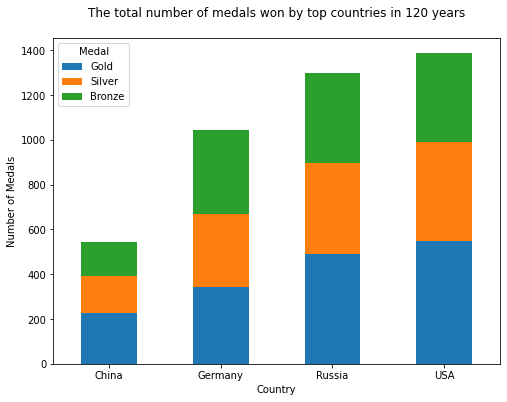

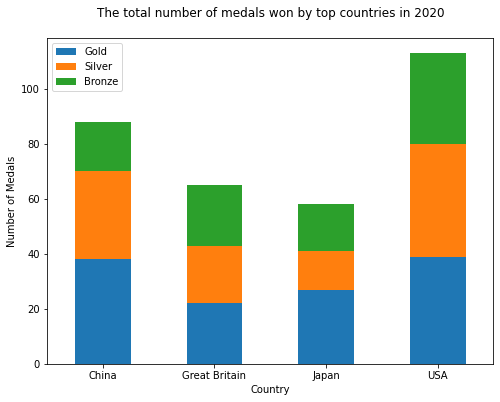

In [261]:
# List of top countries
top_countries = ['USA', 'Russia', 'Germany', 'China']

# row mask where countries match
row_mask_2 = medal_tally_agnostic['Team'].map(lambda x: x in top_countries)

# Pivot table to calculate sum of gold, silver and bronze medals for each country
medal_tally_specific = pd.pivot_table(medal_tally_agnostic[row_mask_2],
                                     index = ['Team'],
                                     columns = 'Medal',
                                     values = 'Medal_Won_Corrected',
                                     aggfunc = 'sum',
                                     fill_value = 0).drop('DNW', axis = 1)

# Re-order the columns so that they appear in order on the chart.
medal_tally_specific = medal_tally_specific.loc[:, ['Gold', 'Silver', 'Bronze']]

medal_tally_specific.plot(kind = 'bar', stacked = True, figsize = (8,6), rot = 0)
xlabel('Country')
ylabel('Number of Medals')

#Comparing the stats from past years and 2020
top_countries = medals21.head(4).drop('Total', axis = 1)

# Pivot table to calculate sum of gold, silver and bronze medals for each country
medal_tally_specific = pd.pivot_table(top_countries,
                                     index = 'Country')

plt.title("The total number of medals won by top countries in 120 years\n")
medal_tally_specific = medal_tally_specific.loc[:, ['Gold', 'Silver', 'Bronze']]

medal_tally_specific.plot(kind = 'bar', stacked = True, figsize = (8,6), rot = 0)
xlabel('Country')
ylabel('Number of Medals')
plt.title("The total number of medals won by top countries in 2020\n")
